<h1>Evolução Quântica em Tempo Real usando Trotterização<h1>


Como técnica de evolução em tempo real, a Trotterização ou Evolução em Tempo Real(ETR) consiste na aplicação sucessiva de uma porta quântica, assumida para aproximar a evolução temporal de um sistema para uma espaço de tempo. Utilizando a equação de Schrodinger, a evolução temporal de um sistema que inicialmente está no estato $|\psi(0)\rangle$ assume a forma: $|\psi(t)\rangle = e^{-iHt}|\psi(0)\rangle$, onde H é o hamiltoniano independente do tempo sob o qual o sistema é submetido. Nós consideraremos um Hamiltoniano que pode ser escrito como uma soma ponderada de termos de Pauli $H = \sum_j a_j H_j$, com $h_j$ representando o produto tensorial de termos de Pauli atuando nos n qubits. Assim, a sequência de portas que se aproximam de um único passo da evolução é encontrada sob a suposição de que o produto dos exponenciais da matriz é uma boa aproximação para a soma dos exponenciais da matriz:

$|\psi(t)\rangle \approx \left( \prod_j e^{\frac{-ia_j H_j t}{r}}\right)^{r} |\psi(0)\rangle,$

onde $t/r$ é uma fatia do tempo (etapa da evolução temporal) que estamos escolhendo. Como resultado, é criado uma porta que é aplicada $r$ vezes. Um intervalo de tempo menor leva a uma aproximação mais precisa. No entando, isso também leva a circuitos mais profundos que, na prática, levam a um maior acúmulo de erros, tornando-se um aspecto crítico especialmente me dispositivos NIQS. Para os propósitos deste tutorial, todas as simulações são "Statevector simulator", que incluem nenhum ruído de disparo ou de hardware.

Neste tutorial, implementaresmo evoluções em tempo real usando a classe TrotterQRTE. Para ilustrar isso, estudaremos a evolução temporal do modelo de ISING em redes lineares de sítios $L=2$ e $L=6$. Essas redes consistem em uma matriz de spins $\sigma_i$ que interagem apenas com seus vizinhos mais próximos. Esses spins podem ter duas orientações: $\uparrow$ e $\downarrow$, que correspondem a uma magnetização de +1 e -1, respectivamente.

$H = -J\sum^{L-2}_{i=0}\sigma_{i}\sigma_{i+1} -h\sum_{L-1}^{i=0}\sigma_i$,

onde $J$ descreve a energia de interação, e $h$ a magnetude do campo externo. Vamos escrever esta expressão usando matrizes de Pauli, e considerando que o campo externo tem ângulo $\alpha$ em relação à direção transveral,

$H= -J\sum^{L-2}_{i=0} Z_i Z_{i+1} - h\sum^{L-1}_{i=0}( \sin{\alpha Z_i} + \cos{\alpha X_i})$.

Na base computacional, o sistema vai ser encodado como a seguir:

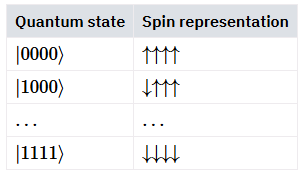

Primeiro, criaremos uma função que recebe os parâmetros do sistema $L$, $J$, $h$ e $\alpha$, e retorna nosso Hamiltoniano como um SparsePauliOp. Um SparsePauliOp é uma representação espaçada de um operador em termo dos termos de Pauli ponderados.

In [2]:
from qiskit.quantum_info import SparsePauliOp
from math import sin, cos


def get_hamiltonian(L, J, h, alpha=0):


    # Lista de termos da hamiltoniana com 3-tuplas contendo
    # (1) a string de Pauli,
    # (2) os índices de qubits correspondente à string de Pauli,
    # (3) o coeficiente
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, L - 1)]
    Z_tuples = [("Z", [i], -h * sin(alpha)) for i in range(0, L)]
    X_tuples = [("X", [i], -h * cos(alpha)) for i in range(0, L)]

    # Criamos o Hamiltoniano como um SparsePauliOp, através do método 'from_sparse_list', e multiplicamos pelo termo de interação
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()

Vamos começar e criar um hamiltoniano como um operador para $L=2$, e escolha de $J=0.2$, $h=1$ e $\alpha = \pi/8$:

In [3]:
from math import pi

H = get_hamiltonian(L=4, J=0.2, h=1.0, alpha=pi / 8)
H

SparsePauliOp(['IIZZ', 'IZZI', 'ZZII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIIX', 'IIXI', 'IXII', 'XIII'],
              coeffs=[-0.2       +0.j, -0.2       +0.j, -0.2       +0.j, -0.38268343+0.j,
 -0.38268343+0.j, -0.38268343+0.j, -0.38268343+0.j, -0.92387953+0.j,
 -0.92387953+0.j, -0.92387953+0.j, -0.92387953+0.j])

Vamos crir uma instância de TimeEvolutionProblem. Conceitualmente, ela contém todas as informações relevantes sobre o problema físico. No nosso caso, passaremos o nosso Hamiltoniano, um estado inicial, um tempo final. Como estado inicial, pegaremos um spin para cima e um para baixo.

In [4]:
from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem

final_time = 1.6


# Primeiro spin para cima, segundo spin para baixo
# (lembre-se de que os rótulos são interpretados da direita para a esquerda)
initial_state = Statevector.from_label("1111")

problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time)

Agora podemos criar uma instância de TrotterQRTE. Conceitualmente, ela contém as informações relevantes para resolver um problema físico, que é feito por meio do método 'evolve'.

In [5]:
from qiskit_algorithms import TrotterQRTE

trotter = TrotterQRTE()
result = trotter.evolve(problem)

Nosso estado evoluído está no atributo 'evolved_state' do resultado, que é um QuantumCircuit,

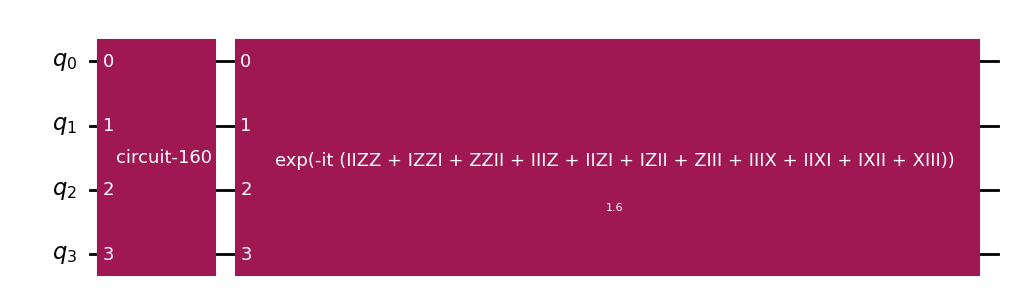

In [6]:
result.evolved_state.draw("mpl")

Ao decompor sequencialmente o circuito, podemos mostrá-lo em termos de portas padrão da Biblioteca de Circuito do Qiskit.

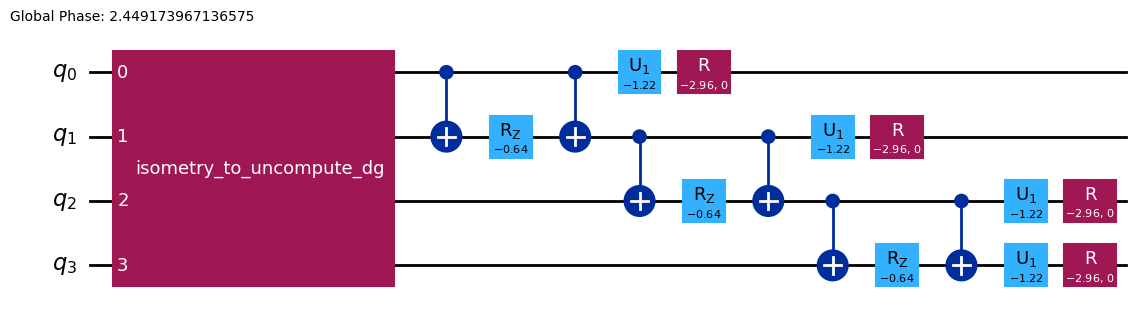

In [41]:
result.evolved_state.decompose(reps=2).decompose("disentangler_dg").decompose(
    "multiplex1_reverse_dg"
).draw("mpl")

O estado evoluído, como todos os 'QuantumCircuits', pode ser transformado em um 'StateVector'.

In [49]:
statevector = Statevector(result.evolved_state)
print(statevector)

Statevector([ 3.37319760e-20+5.87836396e-20j,
              3.60633143e-15-1.94205809e-15j,
              3.60633143e-15-1.94205809e-15j,
             -1.21378630e-10-2.25395714e-10j,
              3.60632536e-15-1.94206063e-15j,
             -1.21378630e-10-2.25395714e-10j,
             -1.21378630e-10-2.25395714e-10j,
             -1.40872321e-05+7.58616440e-06j,
              3.67397747e-15-2.10824850e-15j,
             -1.21378630e-10-2.25395714e-10j,
             -1.21378630e-10-2.25395714e-10j,
             -1.40872321e-05+7.58616440e-06j,
             -1.21378789e-10-2.25395335e-10j,
             -1.40872321e-05+7.58616440e-06j,
             -1.40872321e-05+7.58616440e-06j,
              4.74135275e-01+8.80452009e-01j],
            dims=(2, 2, 2, 2))


Vamos descobrir o efeito da direção do campo após um certo tempo $t=1.6$. Note que as unidades de tempo são o inverso das unidades do Hamiltoniano. Para os propósitos deste tutorial, deixamos todas as unidades adimensinais.

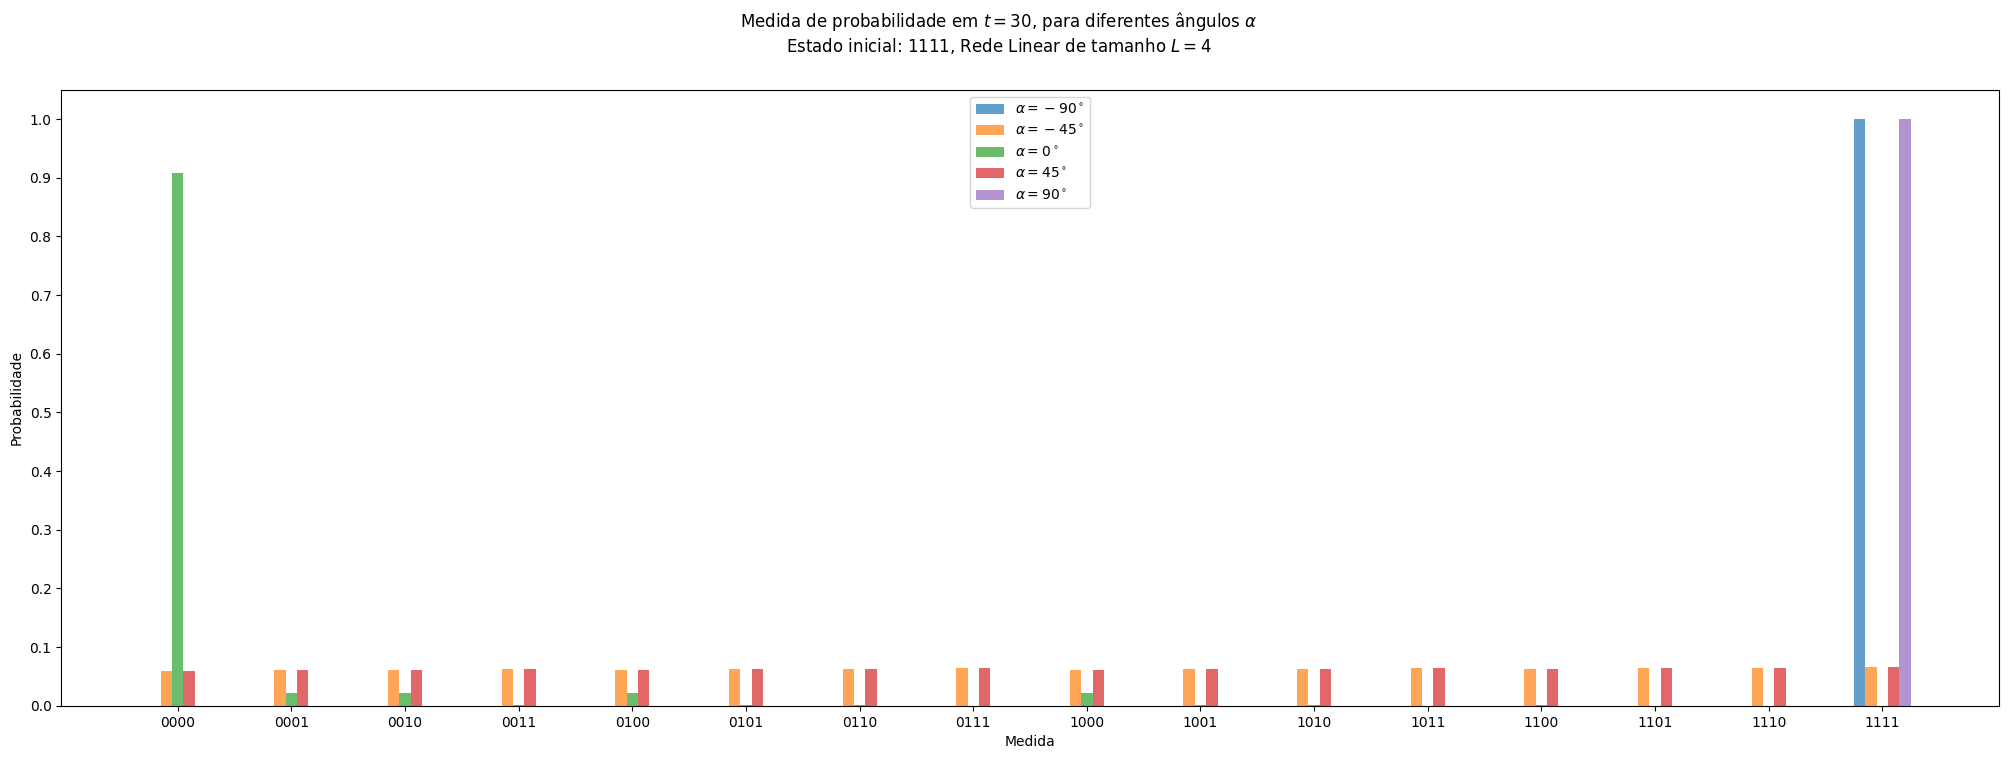

In [110]:
import numpy as np
import matplotlib.pyplot as plt

bar_width = 0.1

# Preparemos um estado inicial ↑↓ (01).
# Note que 'StateVector' e 'SparsePauliOp' interpretam os qubits da direita para a esquerda.
initial_state = Statevector.from_label("1111")
trotter = TrotterQRTE()
final_time = 30
eps = 1e-5
ELI = 4

# Aumentando o tanho da figura
# Colocando a escala do eixo-y de 0.1 em 0.1
plt.figure(figsize=(25, 8))
plt.yticks(np.arange(0, 1.1, 0.1))

# Criamos a lista de ângulos em radianos, com um pequeno epsilon
# o campo exatamente longitudinal, que não apresentaria nenhuma dinâmica
alphas = np.linspace(-np.pi / 2 + eps, np.pi / 2 - eps, 5)

for i, alpha in enumerate(alphas):
    H_alpha = get_hamiltonian(L= ELI, J=0.2, h=1.0, alpha=alpha)
    problem = TimeEvolutionProblem(H_alpha, initial_state=initial_state, time=final_time)
    result = trotter.evolve(problem)
    evolved_state = Statevector(result.evolved_state)
    # Dicionário de probabilidades
    amplitudes_dict = evolved_state.probabilities_dict()
    labels = list(amplitudes_dict.keys())
    values = list(amplitudes_dict.values())
    # Converter ângulo em graus
    alpha_str = f"$\\alpha={int(np.round(alpha * 180 / pi))}^\\circ$"
    plt.bar(np.arange(pow(ELI,2)) + i * bar_width, values, bar_width, label=alpha_str, alpha=0.7)

plt.xticks(np.arange(pow(ELI,2)) + 2 * bar_width, labels)
plt.xlabel("Medida")
plt.ylabel("Probabilidade")
plt.suptitle(
    f"Medida de probabilidade em $t={final_time}$, para diferentes ângulos $\\alpha$\n"
    f"Estado inicial: 1111, Rede Linear de tamanho $L={ELI}$"
)
plt.legend()

Preparamos um sistema inicialmente com uma sequencia de spins $ \downarrow \downarrow \downarrow \downarrow$ que corresponde a $|\psi(0)\rangle = |1111\rangle$. Depois de deixa-lo evoluir por $t=1.6$ sob um campo transversal $(\alpha = 0º)$, temos quase garantia de medir $\downarrow \uparrow$,ou seja, temos uma troca de spin.(Observe que os rótulos são interprestado da direita para a esqueda). Se o campo for longitudinal $(\alpha = \pm 90º)$, não teremos evolução, portando mediremos o sistema como ele foi inicialmente preparado, $\uparrow \downarrow$. Com ângulos intermediários, em $(\alpha = 45º)$, sremos capazes de medir todas as combinações com diferentes probabilidades, sendo uma troca de spin a mais provável com uma probabilidade de 67%.

<h1>Operadores Auxiliares</h1>

Vamos dar uma olhada em outro revurso do 'TroterQRTE'. Agora exploraremos sua capacidade de executar evoluções temporais de uma sistema, enquanto mantemos o controle de alguns observáveis. O sistema que agora consideramos tem um tamanho de $L=6$.

In [111]:
from math import pi

L = 4
H = get_hamiltonian(L=L, J=0.2, h=1.2, alpha=pi / 8)

A instância 'TrotterQRTE' agora será criada com um argumento de 'num_timesteps' e uma primitiva 'Estimator'. A primitiva 'Estimator' do Qiskit estima valores esperados de observáveis, $\langle \psi | \hat{O} |\psi \rangle$.

In [140]:
from qiskit_algorithms import TrotterQRTE
from qiskit.primitives import Estimator

num_timesteps = 1000
trotter = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator())

/tmp/ipykernel_10635/1455968212.py:5: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator())


Vamos definir um operador de magnetização $\sum_i Z_i$, e um operador de correlação de spin médio $\sum_i Z_i Z_{i+1}/(L-1)$.

In [141]:
magnetization_op = SparsePauliOp.from_sparse_list(
    [("Z", [i], 1.0) for i in range(0, L)], num_qubits=L
)
correlation_op = SparsePauliOp.from_sparse_list(
    [("ZZ", [i, i + 1], 1.0) for i in range(0, L - 1)], num_qubits=L
) / (L - 1)

Nosso novo estado inicial terá os dois spins do meio voltandos para baixo, e o 'TimeEvolutionProblem' incorporará alguns observáveis que serão monitorados: 1. A energia, ou seja, o valor esperado do Hamiltoniano $\langle H \rangle$. 2. A magnetização $\langle \sum_i Z_i \rangle$.  3. A correlação média do spin, $\langle \sum_i Z_i Z_{i+1}\rangle/(L-1)$.

In [142]:
final_time = 100
initial_state = Statevector.from_label("1111")
problem = TimeEvolutionProblem(
    H,
    initial_state=initial_state,
    time=final_time,
    aux_operators=[H, magnetization_op, correlation_op],
)

Novamente, deixamos nosso 'TrotterQRTE' evoluir nossa instância de problema recém-criada.

In [143]:
result = trotter.evolve(problem)

O novo resultado também apresenta um atributo 'Observables'. Vamos extrair os observaveis armazeados nele.

In [144]:
import numpy as np

observables = np.array(np.array(result.observables)[:, :, 0])
observables.shape

(1001, 3)

Text(0.5, 0.98, 'Evolução Observável com nº de passos = 1000 ')

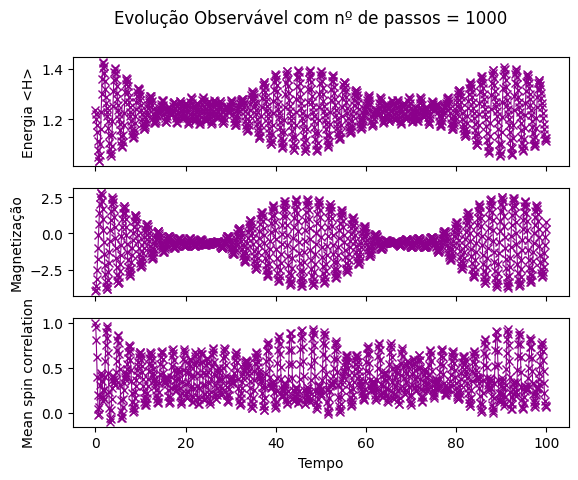

In [145]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, sharex=True)
times = np.linspace(0, final_time, num_timesteps + 1)  # includes initial state
axes[0].plot(
    times, observables[:, 0], label="1ª Ordem", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[1].plot(
    times, observables[:, 1], label="1ª Ordem", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[2].plot(
    times, observables[:, 2], label="1ª Ordem", marker="x", c="darkmagenta", ls="-", lw=0.8
)
axes[0].set_ylabel("Energia <H>")
axes[1].set_ylabel("Magnetização")
axes[2].set_ylabel("Mean spin correlation")
axes[2].set_xlabel("Tempo")
plt.suptitle(f"Evolução Observável com nº de passos = {num_timesteps} ")

Vamos verificar esses resultados comparando esses valores esperados usando a evolução de Trotter com os valores exatos. Para esse fim, avaliamos diretamente a expressão discutida na introdução,

$|\psi(t)\rangle = e^{-iHt}|\psi(0)\rangle$,

em cada um dos passos de tempo usandos pelo Trotter. Calculamos esse exponencial usando a função 'linalg.expm' do 'SciPy' e, então, deixamos o sistema inicial evoluir usando o método do 'StateVector'. Isso se torna muito custoso para ser executado em sistema maiores muito rapidamente.

In [146]:
import scipy as sc

H_array = H.to_matrix()

# We define a slightly denser time mesh
exact_times = np.linspace(0, final_time, 101)

# We compute the exact evolution using the exp
exact_evolution = [
    initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times
]

Tendo os vetores de estado exatos, calculamos a evolução exata dos valores esperados dos nosso operadores.

In [147]:
exact_energy = np.real([sv.expectation_value(H) for sv in exact_evolution])
exact_magnetization = np.real([sv.expectation_value(magnetization_op) for sv in exact_evolution])
exact_correlation = np.real([sv.expectation_value(correlation_op) for sv in exact_evolution])

Incorpoeramos a evoluição exata dos operadores juntamente com os valores esperados resultantes da Trotterização.

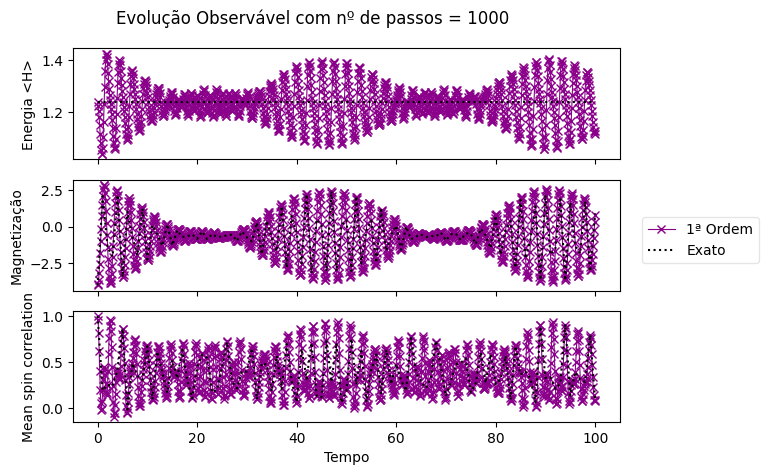

In [148]:
axes[0].plot(exact_times, exact_energy, c="k", ls=":", label="Exato")
axes[1].plot(exact_times, exact_magnetization, c="k", ls=":", label="Exato")
axes[2].plot(exact_times, exact_correlation, c="k", ls=":", label="Exato")
# Select the labels of only the first axis
legend = fig.legend(
    *axes[0].get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
fig.tight_layout()
fig

Vemos que, como uma aproximação, uma evolução de Pauli-Trotter não está muito longe da solução exata, mas a precisão é limitada. Vamos ver como encontrar fórmulas de ordem superior para resolver isso.

<h1>Visão geral da fórmula do produto</h1>

Se não for especificado, a fórmula de produto padrão que o 'TrotterQRTE' usa é a fórmula de produto de Lie, que é de primeira ordem. No QISKIT, isso é implementado na classe 'LieTrotter'. Uma fórmula de primeira ordem consiste na aproximação declarada na introdução, onde a matriz exponencial de uma soma é aproximada por uma produto de matrizes exponenciais:

$e^{A+B} \approx e^{A}e^{B}$

Sabendo disso, podemos dar uma olhada no circuito que executa um único passo de Trotter.


Trotter step with Lie-Trotter
-----------------------------

                  Depth: 11
             Gate count: 17
    Nonlocal gate count: 6
         Gate breakdown: CX: 6, U1: 4, R: 4, RZ: 3



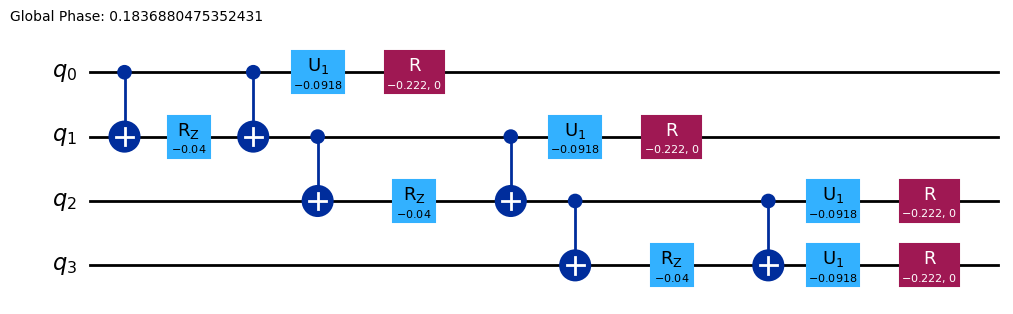

In [92]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter

dt = final_time / num_timesteps
trotter_step_first_order = PauliEvolutionGate(H, dt, synthesis=LieTrotter())

# Cria um circuito vazio
circuit = QuantumCircuit(H.num_qubits)
circuit.append(trotter_step_first_order, range(H.num_qubits))
circuit = circuit.decompose(reps=2)

#vamos printar alguns status
print(
    f"""
Trotter step with Lie-Trotter
-----------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}
"""
)

# E finalmente plotar o circuito
circuit.draw("mpl")

Existe uma fórmula de segunda ordem, chamada decomposição de 'Suzuki-Trotter', e pode ser usada no Qiskit por meio da classe 'SuzukiTrotter'. usando esta fórmula, uma decomposição de segunda ordem é:

$e^{A+B} \approx e^{B/2}e^{A}e^{B/2}$

Por meio de recursões, aproximações de ordem superior podem ser encontradas.


Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: 22
             Gate count: 33
    Nonlocal gate count: 12
         Gate breakdown: CX: 12, U1: 8, R: 7, RZ: 6




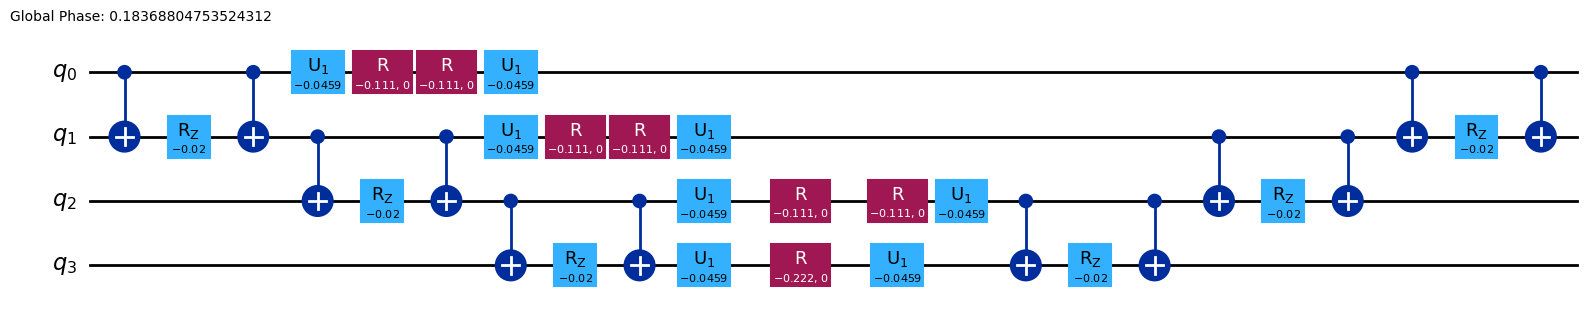

In [96]:
from qiskit.synthesis import SuzukiTrotter

second_order_formula = SuzukiTrotter()  # se não for passado, o pedido padrão é 2
trotter_step_second_order = PauliEvolutionGate(H, dt, synthesis=second_order_formula)
circuit = QuantumCircuit(H.num_qubits)
circuit.append(trotter_step_second_order, range(H.num_qubits))
circuit = circuit.decompose(reps=2)

# vamos printar alguns status
print(
    f"""
Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

"""
)

# e finalmente printar
circuit.draw("mpl")

4ª ordem:


In [97]:
fourth_order_formula = SuzukiTrotter(order=4)
trotter_step_fourth_order = PauliEvolutionGate(H, dt, synthesis=fourth_order_formula)
circuit = QuantumCircuit(H.num_qubits)
circuit.append(trotter_step_fourth_order, range(H.num_qubits))
circuit = circuit.decompose(reps=2)

# Let us print some stats
print(
    f"""
Trotter step with Suzuki Trotter (4th order)
--------------------------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

"""
)


Trotter step with Suzuki Trotter (4th order)
--------------------------------------------

                  Depth: 110
             Gate count: 165
    Nonlocal gate count: 60
         Gate breakdown: CX: 60, U1: 40, R: 35, RZ: 30




Por fim, vamos realizar uma simulação de quarta ordem.

In [98]:
from qiskit.synthesis import SuzukiTrotter

trotter = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=num_timesteps, estimator=Estimator())
problem = TimeEvolutionProblem(
    H,
    initial_state=initial_state,
    time=final_time,
    aux_operators=[H, magnetization_op, correlation_op],
)
result = trotter.evolve(problem)
observables_order4 = np.array(np.array(result.observables)[:, :, 0], dtype=np.float64)

/tmp/ipykernel_10635/940414233.py:3: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  trotter = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=num_timesteps, estimator=Estimator())


e Plotar os resultados

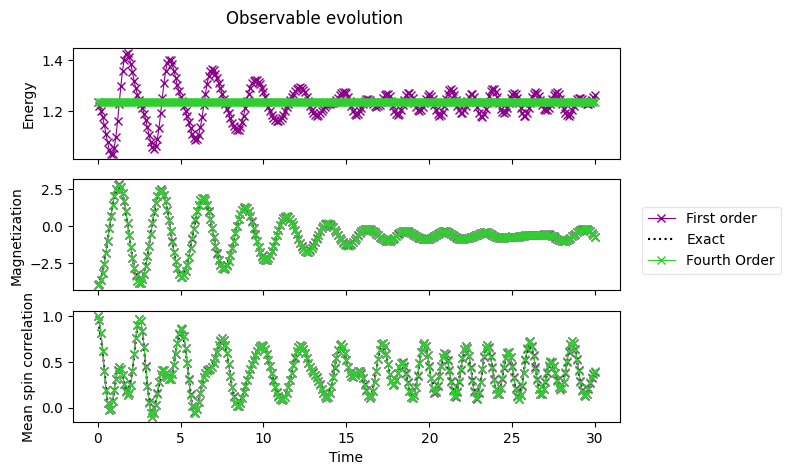

In [99]:
axes[0].plot(
    times, observables_order4[:, 0], label="Fourth Order", marker="x", c="limegreen", ls="-", lw=0.8
)
axes[1].plot(
    times, observables_order4[:, 1], label="Fourth Order", marker="x", c="limegreen", ls="-", lw=0.8
)
axes[2].plot(
    times, observables_order4[:, 2], label="Fourth Order", marker="x", c="limegreen", ls="-", lw=0.8
)

# Replace the legend
legend.remove()
legend = fig.legend(
    *axes[0].get_legend_handles_labels(),
    bbox_to_anchor=(1.0, 0.5),
    loc="center left",
    framealpha=0.5,
)
fig

Como é de se esperar, podemos ver diretametne que uma fórmula de ordem superior leva a valroes esperados mais precisos

<h1>Gráfico da evolução da magnétização</h1>

Nesta última etapa, pretendemos visualizar a evolução temporal de cada um dos sítios da rede individualmente. Vamos apresentar o valor esperado da magnetização de cada um dos sítios como uma função do tempo em um gráfico colorido. Como o estado inicial era $|\psi(0)\rangle = |001100\rangle$ (sequencia de spins ↑↑↓↓↑↑), no tempo $t=0$ esperamos ver magnetização -1 nos dois sinais do meio e +1 em outros lugares. Durante a evolução, como o gráfico acima sugere, podemos esperar ver oscilações que acabarão diminuindo.

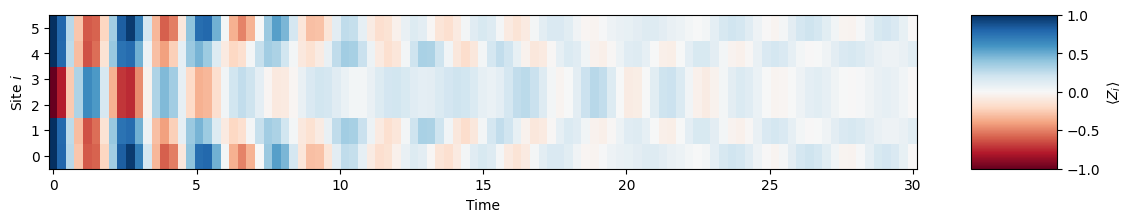

In [26]:
from matplotlib import cm

# An inner list comprehension loops over the terms of the SparsePauliOp magnetization_op,
# which corresponds to the magnetization of each one of the sites
magnetizations = np.real(
    [[sv.expectation_value(term) for term in magnetization_op] for sv in exact_evolution]
)
# The shape of magnetizations is (101, 6), containing <Z>(t) for each site 0, 1, ..., 5
plt.figure(figsize=(14, 2))
# Create the 2-dim xx and yy arrays tiling the grid with the x and y values
xx, yy = np.meshgrid(exact_times, np.arange(L))
plt.pcolor(xx, yy, magnetizations.T, vmin=-1, vmax=+1, cmap="RdBu")
# Force the figure to have all y ticks from 0 to 5
plt.yticks(np.arange(L))
plt.ylabel("Site $i$")
plt.xlabel("Time")
plt.colorbar(label="$\\langle Z_i \\rangle$", aspect=1.8)